In [160]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



In [161]:
df = pd.read_csv('Datasets\sigma_cabs.csv')
df.shape

(131662, 14)

In [162]:
# Remove the column named 'Trip_ID'
df = df.drop('Trip_ID', axis=1)


In [163]:
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [164]:
df.isnull().sum()

Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [165]:
df = df.dropna()
df.shape

(41608, 13)

In [166]:
df.isnull().sum()

Trip_Distance                  0
Type_of_Cab                    0
Customer_Since_Months          0
Life_Style_Index               0
Confidence_Life_Style_Index    0
Destination_Type               0
Customer_Rating                0
Cancellation_Last_1Month       0
Var1                           0
Var2                           0
Var3                           0
Gender                         0
Surge_Pricing_Type             0
dtype: int64

In [167]:
# Define numeric columns
numeric_columns = df.loc[:,df.dtypes!=object].columns
df.loc[:,df.dtypes!=object].head(2)

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
0,6.77,1.0,2.42769,3.905,0,40.0,46,60,2
1,29.47,10.0,2.78245,3.450,0,38.0,56,78,2


In [168]:

# Define categorical columns
categorical_columns = df.loc[:,df.dtypes==object].columns
df.loc[:,df.dtypes==object].head(2)



,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
0,B,A,A,Female
1,B,B,A,Male


In [169]:
# Replace missing values with mean value in numerical columns
# for col in numeric_columns:
#     df[col] = df[col].fillna(df[col].mean())

# for col in categorical_columns:
#     most_frequent = df[col].mode()[0]
#     df[col] = df[col].fillna(most_frequent)

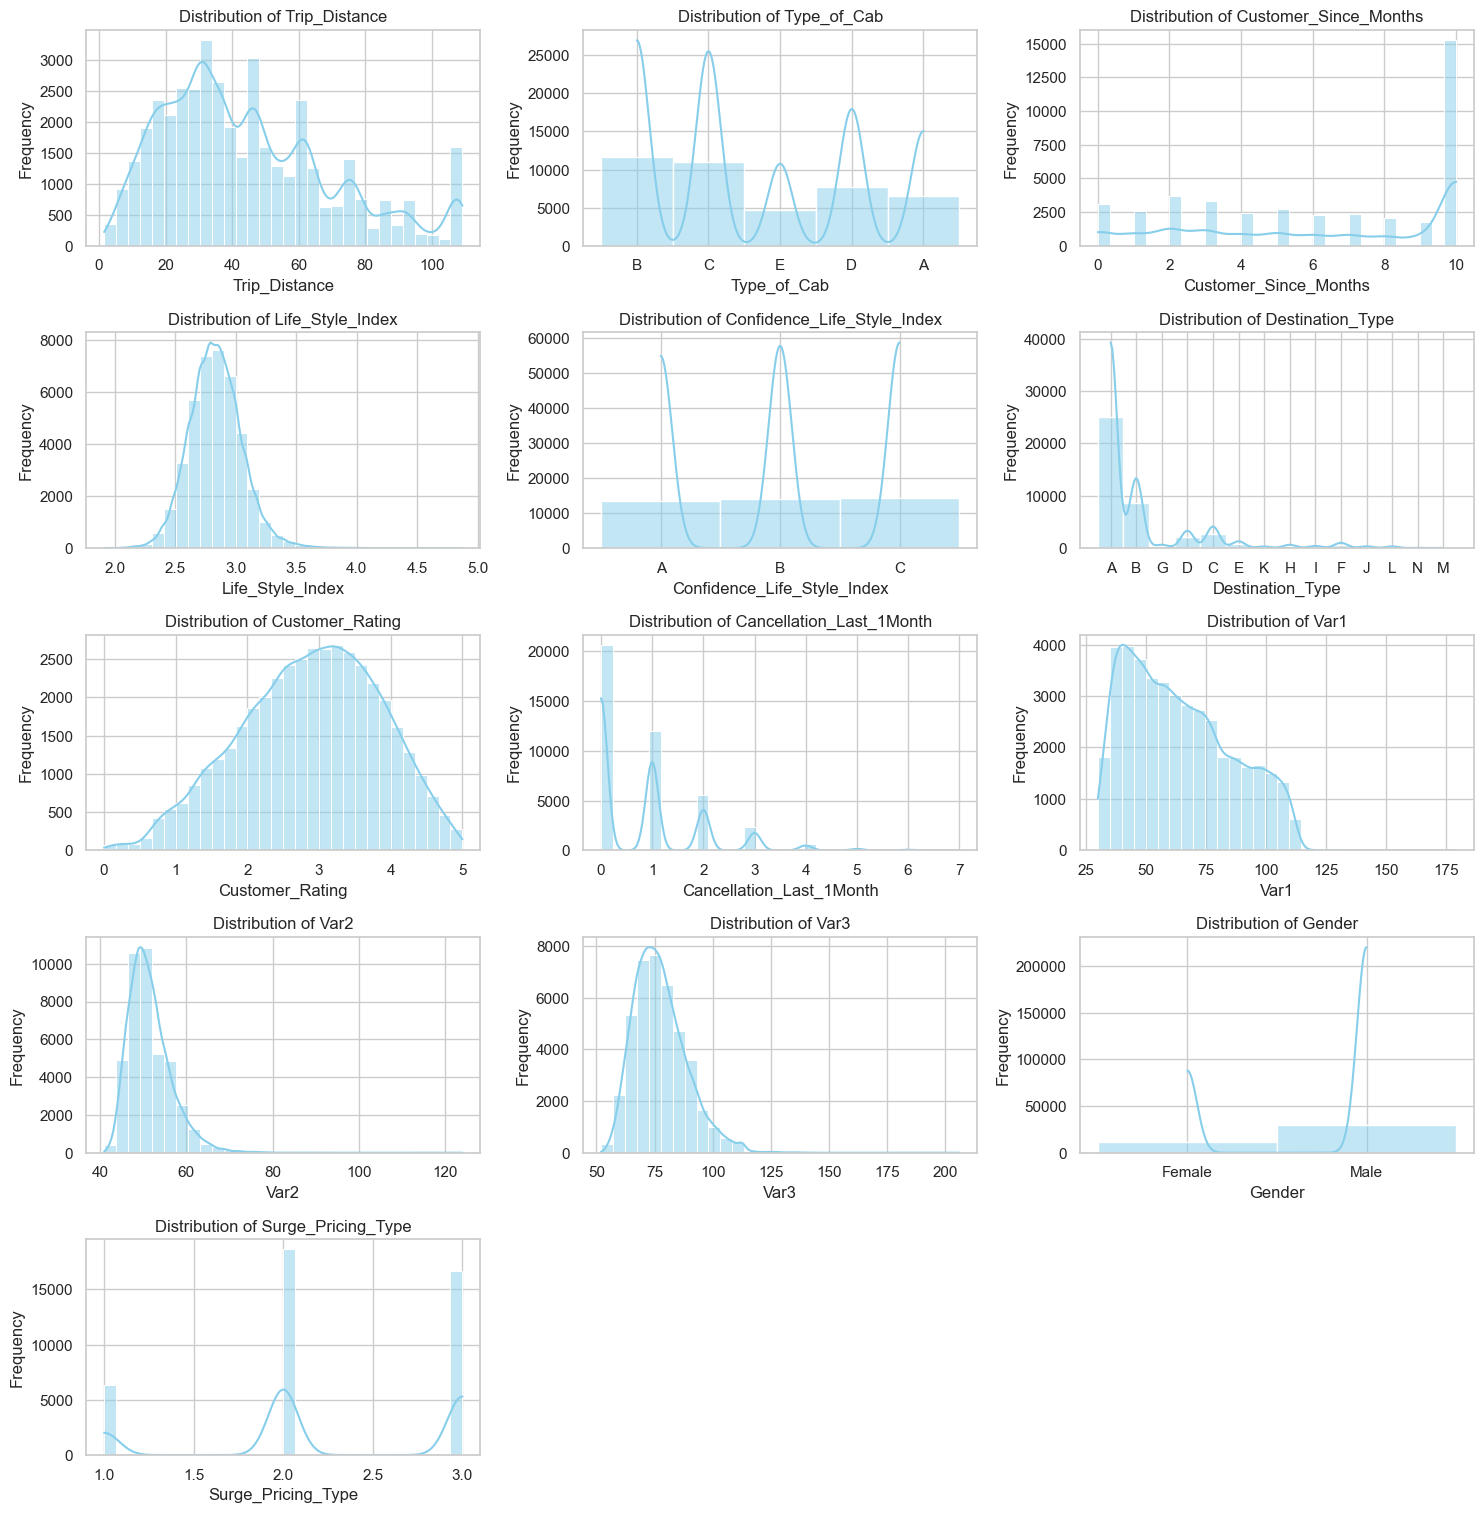

In [170]:
sns.set(style="whitegrid")

# Set the number of subplots
num_subplots = len(df.columns)

# Set the size of the figure
plt.figure(figsize=(15, 3 * num_subplots))

# Loop through each feature and create a histogram
for i, column in enumerate(df.columns):
    plt.subplot(num_subplots, 3, i + 1)
    sns.histplot(df[column], kde=True, color="skyblue", bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()

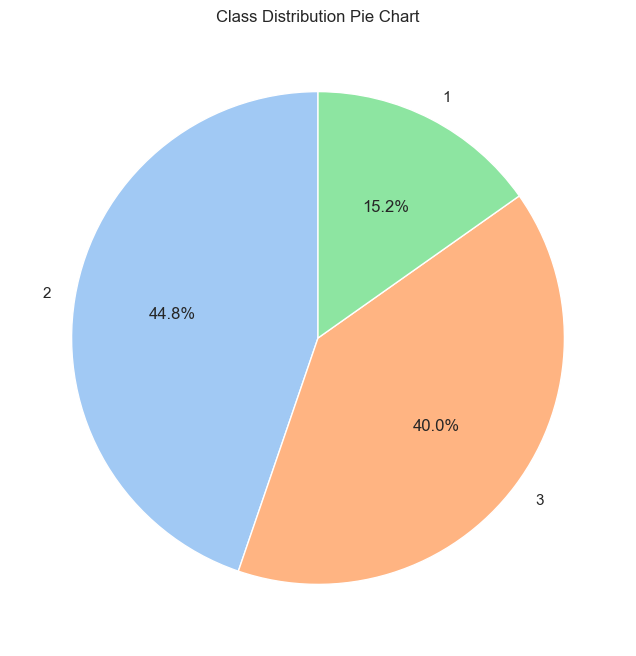

In [171]:
# Count the occurrences of each class
class_counts = df['Surge_Pricing_Type'].value_counts()

# Set up the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Class Distribution Pie Chart')
plt.show()


Box plots for all numerical columns

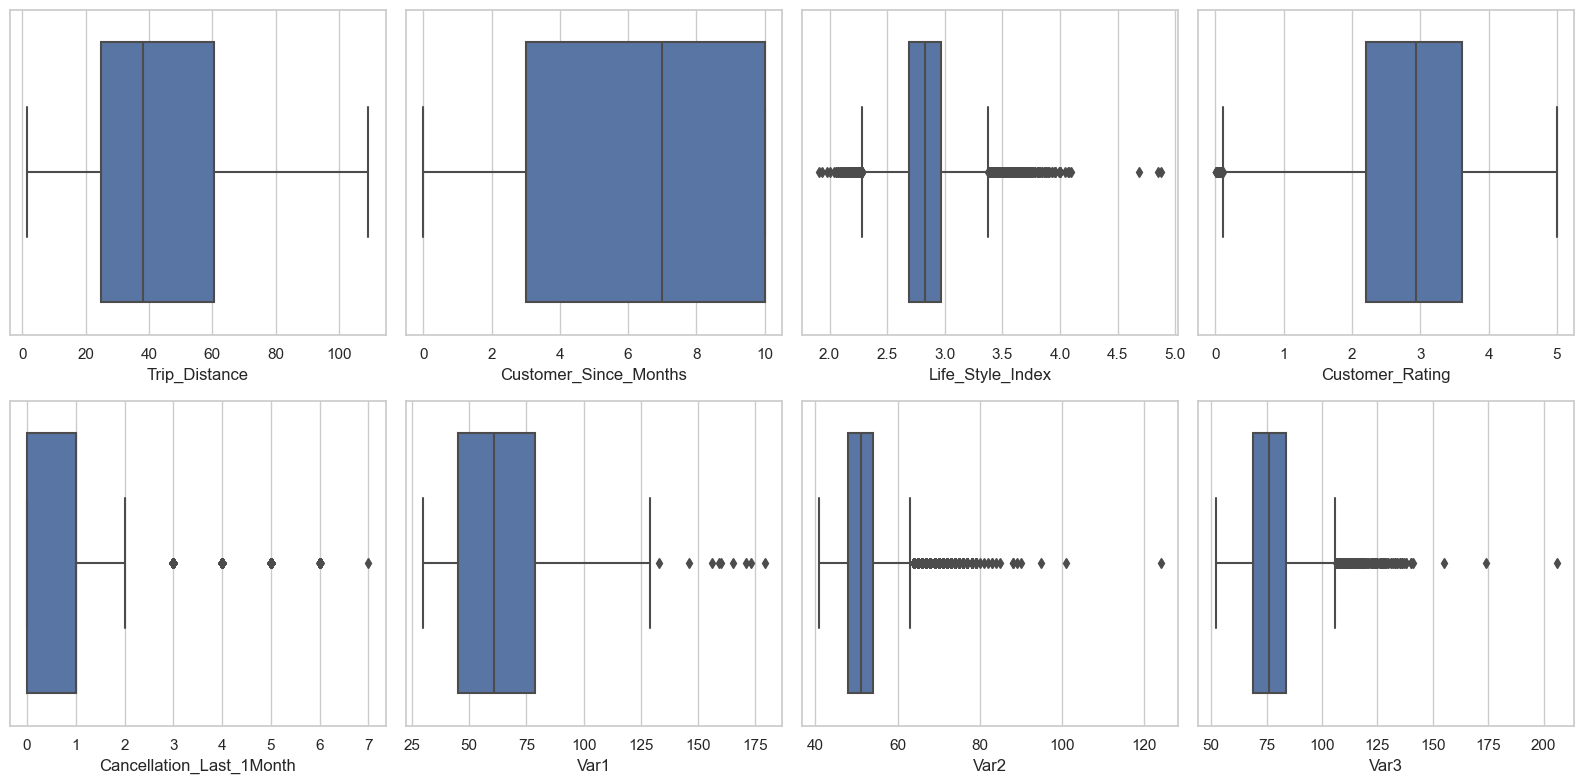

In [172]:
numeric_columns = df.select_dtypes(include='number').columns

plt.figure(figsize=(16, 8))

for i, col in enumerate(numeric_columns, 1):
    if(i <9):
        plt.subplot(2, 4, i)  
        sns.boxplot(x=df[col])

plt.tight_layout()
plt.show()

Var 1 , 2 , 3 are continues variables decided by the company , when we removed them the accuracy of the models dropped a little bit 

In [173]:
numeric_columns = df.select_dtypes(include='number').columns

# Calculate Z-Scores for each numeric column
z_scores = zscore(df[numeric_columns])

threshold = 3

# Identify and remove rows with outliers
df_no_outliers = df[(z_scores < threshold).all(axis=1)]

# Print the shape of the original and modified DataFrames
print("Original DataFrame shape:", df.shape)
print("DataFrame shape after removing outliers:", df_no_outliers.shape)

Original DataFrame shape: (41608, 13)
DataFrame shape after removing outliers: (39732, 13)


In [174]:
df = df_no_outliers

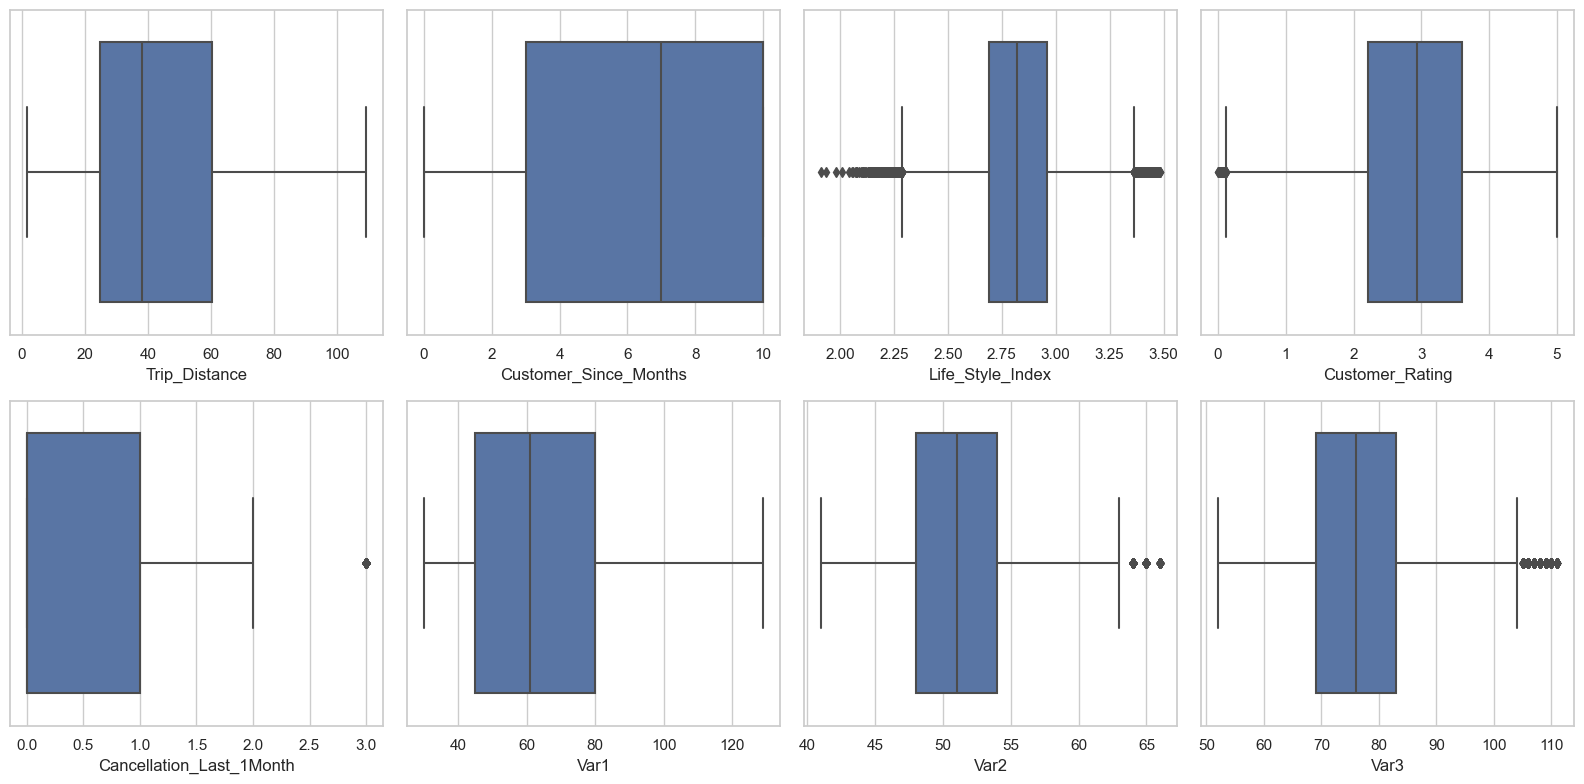

In [175]:
numeric_columns = df.select_dtypes(include='number').columns

plt.figure(figsize=(16, 8))

for i, col in enumerate(numeric_columns, 1):
    if(i <9):
        plt.subplot(2, 4, i)  
        sns.boxplot(x=df[col])

plt.tight_layout()
plt.show()

We tried using label encoder instead of the dummies but it produced less accuracy

In [176]:

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df.head()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type,Type_of_Cab_B,...,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Male
0,6.77,1.0,2.42769,3.90500,0,40.0,46,60,2,True,...,False,False,False,False,False,False,False,False,False,False
1,29.47,10.0,2.78245,3.45000,0,38.0,56,78,2,True,...,False,False,False,False,False,False,False,False,False,True
6,29.72,10.0,2.83958,2.97500,1,83.0,50,75,2,False,...,False,False,False,False,False,False,False,False,False,True
7,18.44,2.0,2.81871,3.58250,0,103.0,46,63,2,True,...,False,False,False,False,False,False,False,False,False,True
10,46.07,10.0,2.95887,2.49125,2,89.0,48,69,2,False,...,False,False,False,False,False,False,False,False,False,False


In [177]:
df.shape

(39732, 29)

In [178]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('Surge_Pricing_Type', axis=1)
y = df['Surge_Pricing_Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use SMOTE to oversample the minority class
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# # Combine the resampled data into a new DataFrame
# df = pd.concat([pd.DataFrame(X_train, columns=X.columns), pd.Series(y_train, name='Surge_Pricing_Type')], axis=1)

# # Check the class distribution in the resampled dataset
# print(df['Surge_Pricing_Type'].value_counts())

# Now you can use df_resampled for training your model


In [179]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [180]:
classifier = OneVsRestClassifier(LogisticRegression())

classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.704     0.556     0.621      1231
           2      0.719     0.816     0.764      3580
           3      0.760     0.706     0.732      3136

    accuracy                          0.732      7947
   macro avg      0.728     0.693     0.706      7947
weighted avg      0.733     0.732     0.729      7947



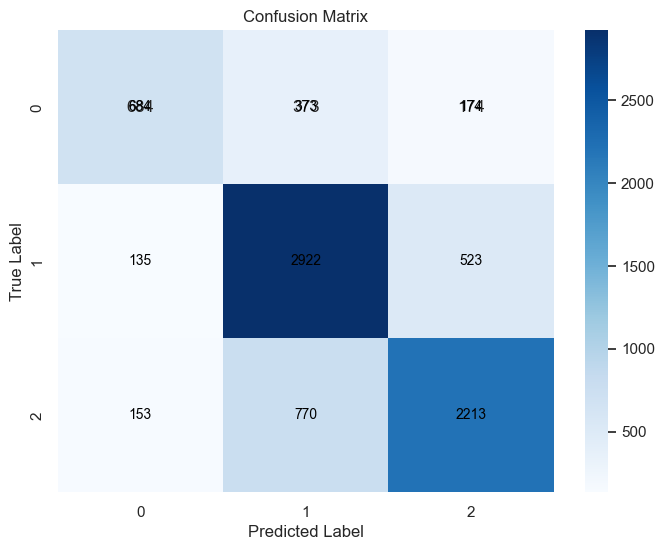

In [181]:
# Create a confusion matrix
cm = confusion_matrix(y_test.ravel(), y_pred.ravel())

# Plot the confusion matrix with numbers
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1' , '2'], yticklabels=['0', '1' , '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the number over each box
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='black', fontsize=10)

plt.show()


In [182]:
classifier_rm = RandomForestClassifier()

classifier_rm.fit(X_train_scaled, y_train)

y_pred_rm = classifier_rm.predict(X_test)

print(classification_report(y_test, y_pred_rm, digits=3))

              precision    recall  f1-score   support

           1      0.750     0.344     0.471      1231
           2      0.672     0.801     0.731      3580
           3      0.677     0.673     0.675      3136

    accuracy                          0.680      7947
   macro avg      0.700     0.606     0.626      7947
weighted avg      0.686     0.680     0.669      7947



C:\Users\Mohamed Reda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


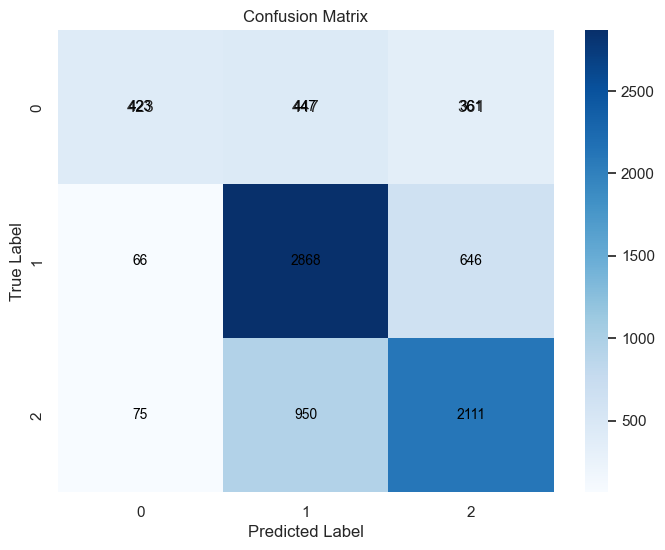

In [183]:
# Create a confusion matrix
cm = confusion_matrix(y_test.ravel(), y_pred_rm.ravel())

# Plot the confusion matrix with numbers
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1' , '2'], yticklabels=['0', '1' , '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the number over each box
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='black', fontsize=10)

plt.show()

In [185]:
# Create a GradientBoostingClassifier
classifier_gb = GradientBoostingClassifier()

# Fit the classifier to the training data
classifier_gb.fit(X_train_scaled, y_train)

# Use the fitted classifier to make predictions on the test data
y_pred_gb = classifier_gb.predict(X_test_scaled)

# Print the classification report for the predictions
print(classification_report(y_test, y_pred_gb, digits=3))


              precision    recall  f1-score   support

           1      0.735     0.542     0.624      1231
           2      0.723     0.817     0.767      3580
           3      0.757     0.722     0.739      3136

    accuracy                          0.737      7947
   macro avg      0.738     0.694     0.710      7947
weighted avg      0.738     0.737     0.734      7947



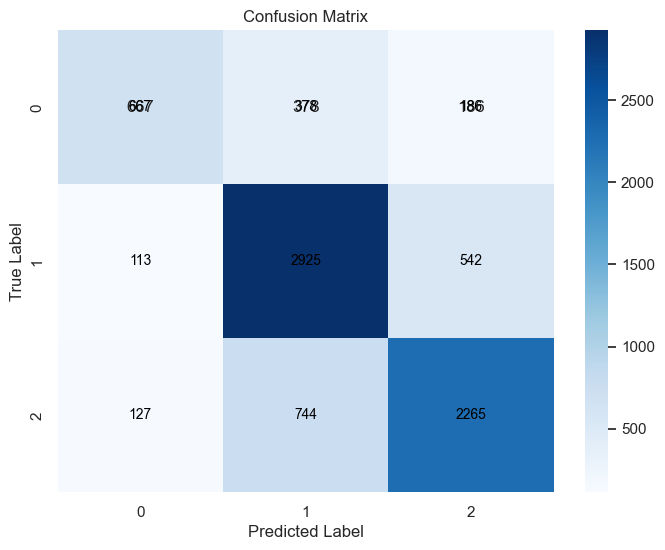

In [186]:
# Create a confusion matrix
cm = confusion_matrix(y_test.ravel(), y_pred_gb.ravel())

# Plot the confusion matrix with numbers
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1' , '2'], yticklabels=['0', '1' , '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the number over each box
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='black', fontsize=10)

plt.show()

in the callbacks we made an early stopping function that stops the model early to aviod overfitting 

In [187]:
# Define the neural network model
ann_model = Sequential()
ann_model.add(Dense(units=256, activation="relu", input_dim=X_train_scaled.shape[1]))
ann_model.add(Dropout(0.3))
ann_model.add(BatchNormalization())
ann_model.add(Dense(units=128, activation="relu"))
ann_model.add(Dropout(0.3))
ann_model.add(BatchNormalization())
ann_model.add(Dense(units=4, activation="softmax"))

# Compile the model
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = ann_model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping])




Epoch 1/30
795/795 [==============================] - 2s 2ms/step - loss: 0.8322 - accuracy: 0.6796 - val_loss: 0.6605 - val_accuracy: 0.7367
Epoch 2/30
795/795 [==============================] - 1s 1ms/step - loss: 0.6917 - accuracy: 0.7203 - val_loss: 0.6589 - val_accuracy: 0.7324
Epoch 3/30
795/795 [==============================] - 1s 1ms/step - loss: 0.6797 - accuracy: 0.7240 - val_loss: 0.6561 - val_accuracy: 0.7357
Epoch 4/30
795/795 [==============================] - 1s 1ms/step - loss: 0.6746 - accuracy: 0.7256 - val_loss: 0.6540 - val_accuracy: 0.7371
Epoch 5/30
795/795 [==============================] - 1s 1ms/step - loss: 0.6740 - accuracy: 0.7273 - val_loss: 0.6520 - val_accuracy: 0.7368
Epoch 6/30
795/795 [==============================] - 1s 1ms/step - loss: 0.6731 - accuracy: 0.7284 - val_loss: 0.6530 - val_accuracy: 0.7373
Epoch 7/30
795/795 [==============================] - 1s 1ms/step - loss: 0.6696 - accuracy: 0.7254 - val_loss: 0.6549 - val_accuracy: 0.7353
Epoch 

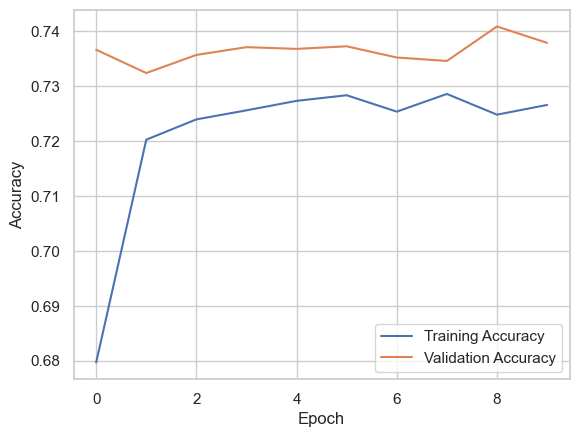

249/249 [==============================] - 0s 524us/step - loss: 0.6536 - accuracy: 0.7306
Test Accuracy: 0.7305901646614075


In [188]:

# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = ann_model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy}')

In [189]:
classifier_svm = SVC()

# Fit the classifier to the training data
classifier_svm.fit(X_train_scaled, y_train)

# Use the fitted classifier to make predictions on the test data
y_pred_svm = classifier_svm.predict(X_test_scaled)

# Print the classification report for the predictions
print(classification_report(y_test, y_pred_svm, digits=3))

              precision    recall  f1-score   support

           1      0.701     0.547     0.614      1231
           2      0.703     0.852     0.770      3580
           3      0.785     0.662     0.718      3136

    accuracy                          0.730      7947
   macro avg      0.729     0.687     0.701      7947
weighted avg      0.735     0.730     0.726      7947



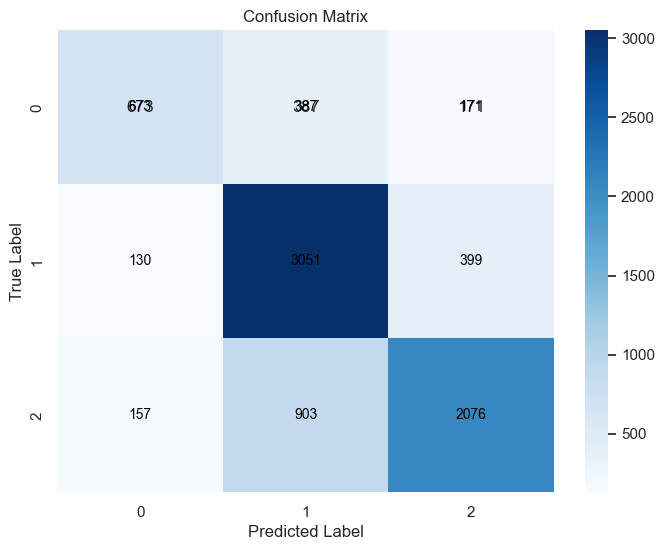

In [190]:
# Create a confusion matrix
cm = confusion_matrix(y_test.ravel(), y_pred_svm.ravel())

# Plot the confusion matrix with numbers
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1' , '2'], yticklabels=['0', '1' , '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the number over each box
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='black', fontsize=10)

plt.show()

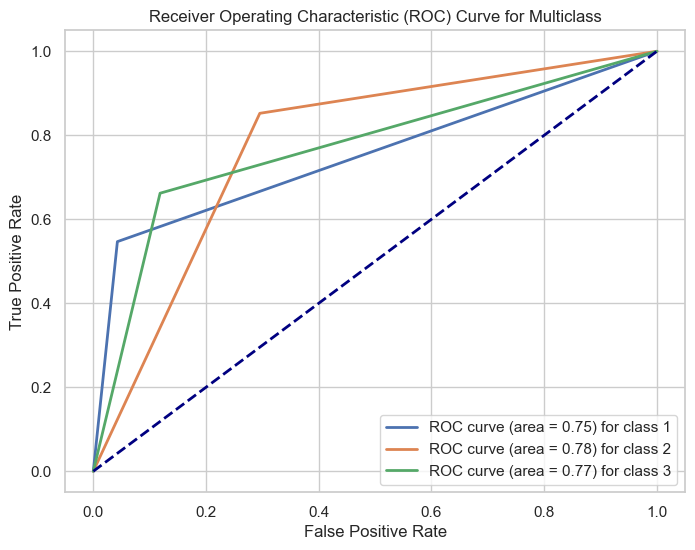

In [191]:
# Transform multiclass labels into binary format
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_svm_bin = lb.transform(y_pred_svm)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_svm_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(lb.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {lb.classes_[i]}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.show()

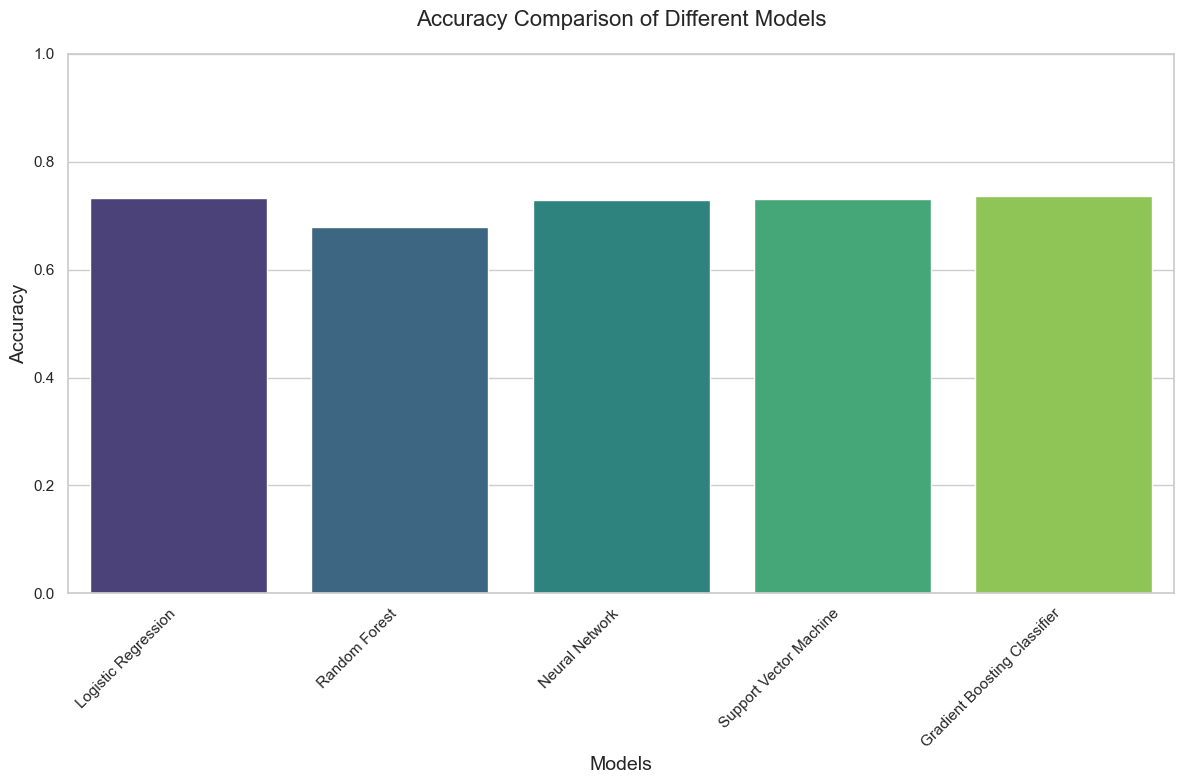

In [192]:

# List of model names and their predictions
models = ['Logistic Regression', 'Random Forest', 'Neural Network', 'Support Vector Machine', 'Gradient Boosting Classifier']
predictions = [y_pred, y_pred_rm, y_pred_svm, (np.argmax(ann_model.predict(X_test_scaled), axis=1)), y_pred_gb]

# Calculate accuracy for each model
accuracies = [accuracy_score(y_test, pred) for pred in predictions]

# Create a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylim(0, 1)  # Set y-axis limits to represent accuracy percentage
plt.title('Accuracy Comparison of Different Models', fontsize=16, pad=20)  # Increase font size and add padding
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of titles
plt.show()
